# West Nile Virus Prediction:- Predict West Nile virus in mosquitos across the city of Chicago

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings

## 1. Analyzing training data<a id='1._Analyzing training data'></a>

In [2]:
#reading training data file
dftrain=pd.read_csv('train.csv')

In [3]:
#Visualizing data 
dftrain.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
#Number of rows and columns in the data
dftrain.shape

(10506, 12)

In [5]:
#Columns data type and their non-null count
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [6]:
#Checking null values
dftrain.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [7]:
#Checking missing values
dftrain.isin(['?']).sum(axis=0)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [8]:
#Checking missing values
dftrain.isin(['-']).sum(axis=0)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [9]:
#Converting date columns to datetime
dftrain['Date']=pd.to_datetime(dftrain['Date'])
display(dftrain.Date.sort_values().head(1))
display(dftrain.Date.sort_values().tail(1))

0   2007-05-29
Name: Date, dtype: datetime64[ns]

10505   2013-09-26
Name: Date, dtype: datetime64[ns]

In [10]:
#Checking unique dates having mosquitos count
print(dftrain['Date'].dt.year.unique())
print(dftrain['Date'].dt.month.unique())
print(len(dftrain.Date.unique()))

[2007 2009 2011 2013]
[ 5  6  7  8  9 10]
95


Training data shows samples collected in every two years from 2007 to 2013. The samples were collected from May to October for 95 days in four years from various locations in the city of Chicago. 

In [11]:
#Counting unique address
print(len(dftrain.Address.unique()))

138


In [12]:
#Sample counts in address
dftrain.Address.value_counts()

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA         750
South Doty Avenue, Chicago, IL, USA                                          542
South Stony Island Avenue, Chicago, IL, USA                                  314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                           185
4200 West 127th Street, Alsip, IL 60803, USA                                 183
                                                                            ... 
3400 West 77th Street, Chicago, IL 60652, USA                                  7
5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA      5
9600 South Longwood Drive, Chicago, IL 60643, USA                              5
2900 West 85th Street, Chicago, IL 60652, USA                                  3
2100 South Hamlin Avenue, Chicago, IL 60623, USA                               2
Name: Address, Length: 138, dtype: int64

Mosquitoes were trapped in 136 unique addresses.  ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA  is the location where the maximum number of samples were collected. 

In [13]:
#Counting unique trap id
len(dftrain.Trap.unique())

136

In [14]:
#Trap id value counts
dftrain.Trap.unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

There exists 136 trap ids. As there are more addresses than trap ids, let's check trap id having more than one address.

In [15]:
#As there are more addresses than trap id, checking trap id having more than one addresses
Trap_address=dftrain.groupby('Trap')['Address'].nunique()
Trap_address[Trap_address>1]

Trap
T009    2
T035    2
Name: Address, dtype: int64

In [16]:
#Trap id T009 corresponds to two different addresses 
dftrain[dftrain.Trap=='T009'].Address.unique()

array(['9100 West Higgins Avenue, Chicago, IL 60656, USA',
       '9100 West Higgins Road, Rosemont, IL 60018, USA'], dtype=object)

In [17]:
#Trap id T035 corresponds to two different addresses 
dftrain[dftrain.Trap=='T035'].Address.unique()

array(['3000 South Hoyne Avenue, Chicago, IL 60608, USA',
       '5100 West 72nd Street, Chicago, IL 60638, USA'], dtype=object)

In [18]:
print(len(dftrain.Street.unique()))

128


In [19]:
dftrain.Street.unique()

array([' N OAK PARK AVE', ' N MANDELL AVE', ' W FOSTER AVE',
       ' W WEBSTER AVE', ' W GRAND AVE', ' W ROOSEVELT', ' W CHICAGO',
       ' N STAVE ST', ' N CANNON DR', ' W 113TH ST', ' S PEORIA ST',
       ' W 95TH ST', ' W 89TH ST', ' N STREETER DR', ' N OAKLEY AVE',
       ' N LONG AVE', ' S CARPENTER ST', ' W HIGGINS AVE',
       ' N PITTSBURGH AVE', ' N OKETO AVE', ' N CALIFORNIA AVE',
       ' W BALMORAL AVE', ' N WESTERN AVE', ' S CENTRAL AVE',
       ' N HUMBOLDT DR', ' S VINCENNES', ' S ASHLAND AVE', ' S STATE ST',
       ' W 127TH PL', ' W AGATITE AVE', ' N AUSTIN AVE',
       ' N ASHLAND AVE OVERPASS', ' N RICHMOND ST', ' N FRANCISCO AVE',
       ' W GRANVILLE AVE', ' W FARWELL AVE', '  W ARMITAGE AVENUE',
       ' S MILLARD AVE', ' N LAWLER AVE', ' W 116TH ST',
       ' S DR MARTIN LUTHER KING JR DR', ' N KEDVALE AVE',
       ' N CAMPBELL AVE', ' N TRIPP AVE', ' N MILWAUKEE AVE',
       ' N AVONDALE AVE', ' N MOSELL AVE', ' N LEMONT AVE',
       ' S WESTERN AVE', ' W BELDE

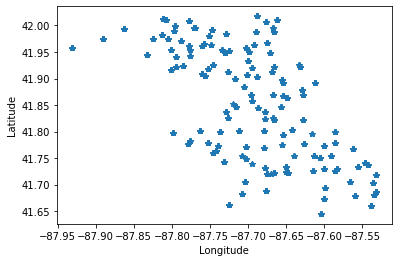

In [20]:
plt.plot(dftrain.Longitude,dftrain.Latitude,'*')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [21]:
#Checking the unique labels and their counts in Wnvpresent column
dftrain.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [22]:
#Computing percentage of wnv present in the moquitos counted at the given address 
Address_count=dftrain.Address.value_counts()
Address_wnv=dftrain.groupby('Address')['WnvPresent'].sum().sort_values(ascending=False)
Address_count=Address_count.to_frame().join(Address_wnv.to_frame())
Address_count = Address_count.rename(columns={'Address': 'Sample', 'WnvPresent': 'Wnv_sample'})
Address_count['Wnv_percent']=Address_count.Wnv_sample*100/Address_count.Sample
Address_count.sort_values(by='Sample',ascending=False)

,Sample,Wnv_sample,Wnv_percent
"ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA",750,66,8.800000
"South Doty Avenue, Chicago, IL, USA",542,41,7.564576
"South Stony Island Avenue, Chicago, IL, USA",314,16,5.095541
"4100 North Oak Park Avenue, Chicago, IL 60634, USA",185,18,9.729730
"4200 West 127th Street, Alsip, IL 60803, USA",183,8,4.371585
...,...,...,...
"3400 West 77th Street, Chicago, IL 60652, USA",7,0,0.000000
"5500 South Doctor Martin Luther King Junior Drive, Chicago, IL 60637, USA",5,0,0.000000
"9600 South Longwood Drive, Chicago, IL 60643, USA",5,0,0.000000
"2900 West 85th Street, Chicago, IL 60652, USA",3,0,0.000000


In [23]:
Address_count.sort_values(by='Wnv_percent',ascending=False)

,Sample,Wnv_sample,Wnv_percent
"6500 North Oak Park Avenue, Chicago, IL 60631, USA",31,6,19.354839
"6000 North Avondale Avenue, Chicago, IL 60631, USA",24,4,16.666667
"6000 West Roscoe Street, Chicago, IL 60634, USA",14,2,14.285714
"7100 North Harlem Avenue, Chicago, IL 60631, USA",50,7,14.000000
"6400 West Strong Street, Chicago, IL, USA",30,4,13.333333
...,...,...,...
"3800 North California Avenue, Chicago, IL 60618, USA",23,0,0.000000
"5300 West Agatite Avenue, Chicago, IL 60630, USA",22,0,0.000000
"1800 West Farwell Avenue, Chicago, IL 60626, USA",22,0,0.000000
"1800 West Leland Avenue, Chicago, IL 60640, USA",21,0,0.000000


ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA  is the location where the maximum number of samples were collected and 8.8% of them contains the West Nile Virus. The highest percentage of virus was seen in the samples collected from 6500 North Oak Park Avenue, Chicago, IL 60631, USA

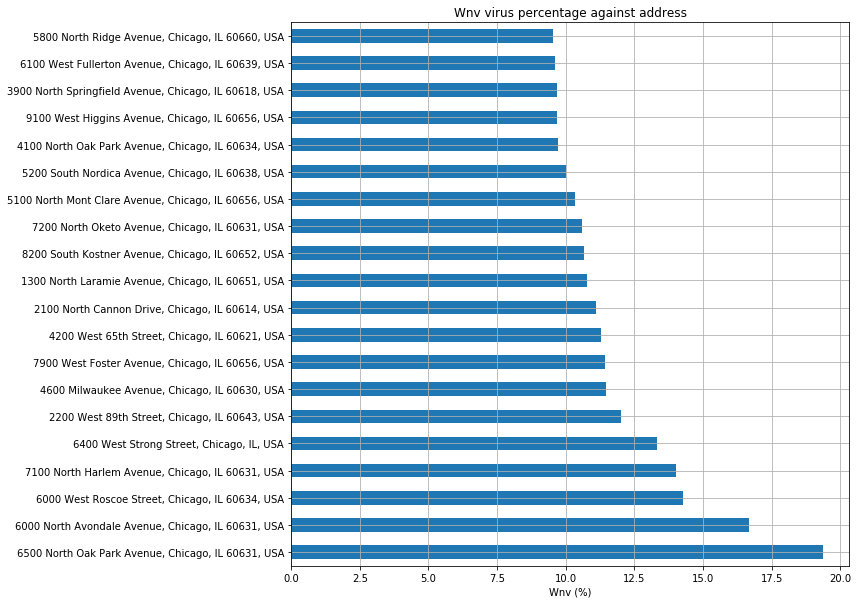

In [24]:
Address_count.Wnv_percent.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 10), title='Wnv virus percentage against address')
plt.xlabel('Wnv (%)')
plt.grid()
plt.show()

In [25]:
#Unique values in column Species
len(dftrain.Species.unique())

7

In [26]:
dftrain.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [27]:
Species_count=dftrain.Species.value_counts()
Species_wnv=dftrain.groupby('Species')['WnvPresent'].sum().sort_values(ascending=False)
Species_count=Species_count.to_frame().join(Species_wnv.to_frame())
Species_count = Species_count.rename(columns={'Species': 'Sample', 'WnvPresent': 'Wnv_sample'})
Species_count['Wnv_percent']=Species_count.Wnv_sample*100/Species_count.Sample
Species_count.reset_index(inplace=True)
Species_count=Species_count.rename(columns={'index': 'Species'})
#Species_count.set_index(["Species"], inplace = True)
Species_count.sort_values(by='Wnv_percent',ascending=False)

,Species,Sample,Wnv_sample,Wnv_percent
2,CULEX PIPIENS,2699,240,8.892182
0,CULEX PIPIENS/RESTUANS,4752,262,5.513468
1,CULEX RESTUANS,2740,49,1.788321
3,CULEX TERRITANS,222,0,0.000000
4,CULEX SALINARIUS,86,0,0.000000
5,CULEX TARSALIS,6,0,0.000000
6,CULEX ERRATICUS,1,0,0.000000


There exists six species of mosquitos. Four species of mosquitoes do not contain the West Nile Virus. As the other two species containing virus were referred to as species together, there must have been a trap of both types of mosquitos in the same sample.

In [28]:
#Plotting mosquito species against their count and wnv percentage
#Create two subplots on 1 row and 2 columns with a figsize of (12, 8)
#fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#Species_count.Sample.plot(kind='bar', ax=ax[0])
#ax[0].set_title('Number of samples vs species ')
#ax[0].set_ylabel('Counts')
#Species_count.Wnv_percent.plot(kind='bar', ax=ax[1])
#ax[1].set_title('Wnv percentage in mosquito species')
#ax[1].set_ylabel('Wnv (%)')
#plt.subplots_adjust(wspace=0.5)
#plt.show()
  

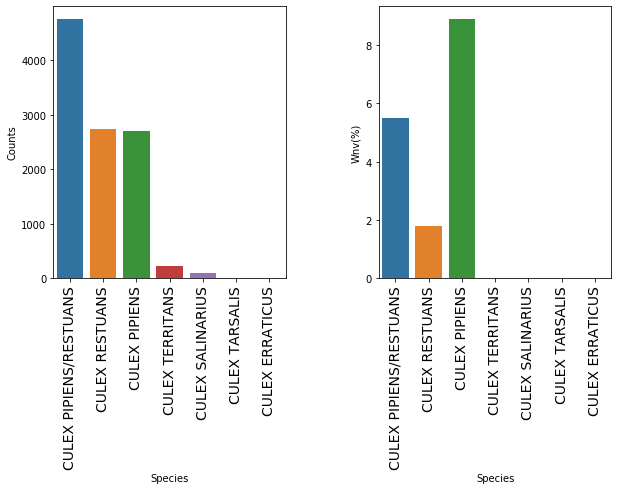

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Species", y="Sample", data=Species_count,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='Counts')
#g1.set(xlabel=None)
g2=sns.barplot(x="Species", y="Wnv_percent", data=Species_count,ax=ax[1])
g2.set_xticklabels(g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='Wnv(%)')
plt.subplots_adjust(wspace=0.4)

plt.show()

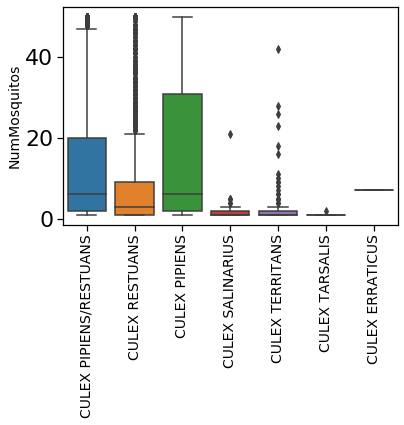

In [30]:
plt.figsize=(5, 5)
sns.set_context("notebook", font_scale=2)
g=sns.boxplot(x="Species", y="NumMosquitos", data=dftrain)
g.set_xticklabels(g.get_xticklabels(), rotation=90,size=14)
g.set(xlabel=None)
g.xaxis.label.set_size(14)
g.yaxis.label.set_size(14)
plt.show()

In [31]:
Species_mosquito_no=dftrain.groupby('Species')['NumMosquitos'].sum().sort_values(ascending=False)
Species_mosquito_no

Species
CULEX PIPIENS/RESTUANS    66268
CULEX PIPIENS             44671
CULEX RESTUANS            23431
CULEX TERRITANS             510
CULEX SALINARIUS            145
CULEX TARSALIS                7
CULEX ERRATICUS               7
Name: NumMosquitos, dtype: int64

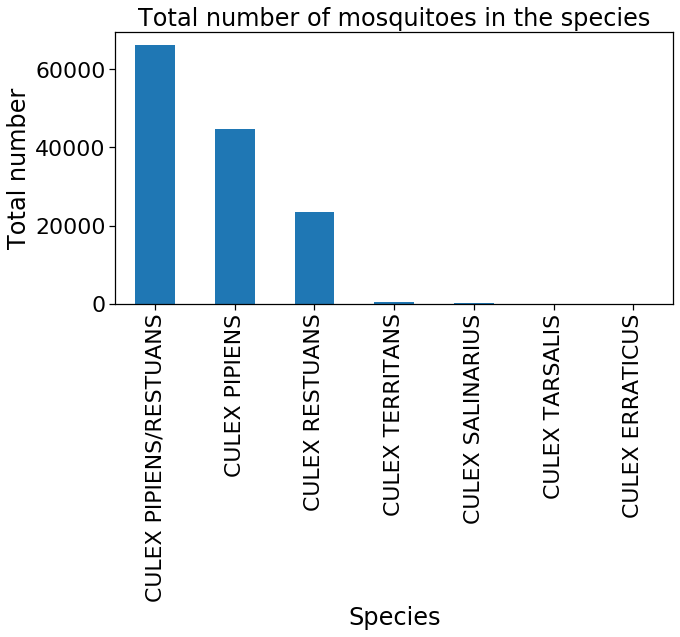

In [32]:
fig = plt.subplots( figsize=(10, 5))
Species_mosquito_no.plot(kind='bar')
plt.title('Total number of mosquitoes in the species')
plt.ylabel('Total number')
plt.xlabel('Species')
plt.show()

In [33]:
display(dftrain.WnvPresent.value_counts())
display(dftrain.WnvPresent.value_counts()/len(dftrain.WnvPresent))

0    9955
1     551
Name: WnvPresent, dtype: int64

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

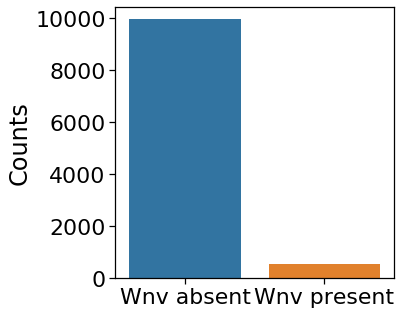

In [34]:
plt.figure(figsize=(5, 5))
x = dftrain.WnvPresent.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present'])
g1=sns.countplot(x)
g1.set(ylabel='Counts')
g1.set(xlabel=None)
plt.show()


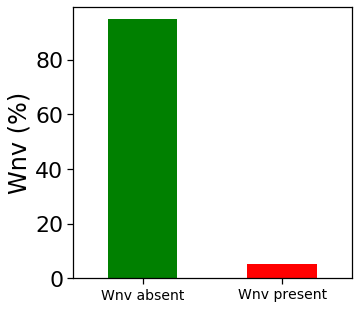

In [35]:
y=x.value_counts()*100/len(dftrain.WnvPresent)
g=y.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present']).plot(kind='bar', color=('g', 'r'),figsize=(5, 5))
plt.ylabel('Wnv (%)')
g.set_xticklabels(g.get_xticklabels(), rotation=0,size=14)
plt.show()

## 2. Analyzing Weather data<a id='2._Analyzing training data'></a>

In [36]:
#Reading weather data
dfweather = pd.read_csv("weather.csv")

In [37]:
#Visualizing first five lines of weather data
dfweather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [38]:
#Number of columns and rows in weather data
dfweather.shape

(2944, 22)

In [39]:
#Columns name in weather data
dfweather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [40]:
#Column's data type and their non-null count
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [41]:
#Checking missing values
dfweather.isin(['?']).sum(axis=0)

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [42]:
#Checking missing values
dfweather.isin(['-']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise        1472
Sunset         1472
CodeSum           0
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [43]:
dfweather.isin(['M']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [44]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [45]:
#Drop Water1 columns having entire missing values
dfweather=dfweather.drop(columns=['Water1'], axis = 1)

In [46]:
dfweather.isin(['  T']).sum(axis=0)

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
CodeSum          0
Depth            0
SnowFall        12
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
dtype: int64

In [47]:
dfweather.SnowFall.value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [48]:
#Drop SnowFall columns as there exist only one row having snowfall data
dfweather=dfweather.drop(columns=['SnowFall'], axis = 1)

In [49]:
dfweather.PrecipTotal.value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
2.90       1
2.17       1
1.11       1
2.43       1
2.35       1
Name: PrecipTotal, Length: 168, dtype: int64

In [50]:
#Replace the trace value with the average between 0 and 0.01
dfweather["PrecipTotal"]=[0.005 if i=='  T' else i for i in dfweather.PrecipTotal]

In [51]:
#Replacing Missing, Trace and - values with nan
dfweather.replace('M', np.nan,inplace=True)
dfweather.replace('-', np.nan,inplace=True)

In [52]:
#Converting Date to datetime
dfweather['Date']=pd.to_datetime(dfweather['Date'])
#Checking unique dates having mosquitos count
print(dfweather['Date'].dt.year.unique())
print(dfweather['Date'].dt.month.unique())
print(len(dfweather.Date.unique()))

[2007 2008 2009 2010 2011 2012 2013 2014]
[ 5  6  7  8  9 10]
1472


In [53]:
#Checking the number of weather stations
dfweather.Station.unique()

array([1, 2])

There exist two weather stations reporting weather parameters. Separate the weather data from station 1 and station 2.

## 2.1 Separating and merging weather parameters from two stations <a id='2.1_Separating and merging weather parameters from two stations'></a>

In [54]:
#Separation station1 and station2 data
dfweather_station1 =dfweather[dfweather['Station'] == 1]
dfweather_station2 =dfweather[dfweather['Station'] == 2]

In [55]:
dfweather_station1=dfweather_station1.drop(columns=['Station'], axis = 1)
dfweather_station2=dfweather_station2.drop(columns=['Station'], axis = 1)

In [56]:
#Merging station1 and station2 data
dfweather_station=dfweather_station1.merge(dfweather_station2,on='Date')

In [57]:
dfweather_station.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunrise_y,Sunset_y,CodeSum_y,Depth_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,NaN,NaN,,NaN,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,NaN,NaN,BR HZ,NaN,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,NaN,NaN,HZ,NaN,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,NaN,NaN,,NaN,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,NaN,NaN,,NaN,0.005,29.46,30.09,11.2,7,11.5


In [58]:
dfweather_station.tail()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunrise_y,Sunset_y,CodeSum_y,Depth_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
1467,2014-10-27,77,51,64,16,51,58,1,0,0618,...,NaN,NaN,RA,NaN,0.02,29.00,29.67,12.7,19,13.6
1468,2014-10-28,68,45,57,10,38,47,8,0,0619,...,NaN,NaN,RA,NaN,0.03,29.23,29.85,14.0,26,14.6
1469,2014-10-29,49,36,43,-4,32,40,22,0,0620,...,NaN,NaN,,NaN,0.00,29.42,30.07,8.5,29,9.0
1470,2014-10-30,51,32,42,-4,34,40,23,0,0622,...,NaN,NaN,RA,NaN,0.005,29.41,30.10,5.9,23,6.5
1471,2014-10-31,47,33,40,-6,25,33,25,0,0623,...,NaN,NaN,RA SN BR,NaN,0.04,29.54,30.20,21.7,34,22.6


In [59]:
dfweather_station.columns

Index(['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'CodeSum_x',
       'Depth_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Tmax_y', 'Tmin_y',
       'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y', 'PrecipTotal_y',
       'StnPressure_y', 'SeaLevel_y', 'ResultSpeed_y', 'ResultDir_y',
       'AvgSpeed_y'],
      dtype='object')

In [60]:
#Merged weather data column information
dfweather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1472 non-null   datetime64[ns]
 1   Tmax_x         1472 non-null   int64         
 2   Tmin_x         1472 non-null   int64         
 3   Tavg_x         1472 non-null   object        
 4   Depart_x       1472 non-null   object        
 5   DewPoint_x     1472 non-null   int64         
 6   WetBulb_x      1469 non-null   object        
 7   Heat_x         1472 non-null   object        
 8   Cool_x         1472 non-null   object        
 9   Sunrise_x      1472 non-null   object        
 10  Sunset_x       1472 non-null   object        
 11  CodeSum_x      1472 non-null   object        
 12  Depth_x        1472 non-null   object        
 13  PrecipTotal_x  1472 non-null   object        
 14  StnPressure_x  1470 non-null   object        
 15  SeaLevel_x     1467 n

In [61]:
dfweather_station.isnull().sum()

Date                0
Tmax_x              0
Tmin_x              0
Tavg_x              0
Depart_x            0
DewPoint_x          0
WetBulb_x           3
Heat_x              0
Cool_x              0
Sunrise_x           0
Sunset_x            0
CodeSum_x           0
Depth_x             0
PrecipTotal_x       0
StnPressure_x       2
SeaLevel_x          5
ResultSpeed_x       0
ResultDir_x         0
AvgSpeed_x          0
Tmax_y              0
Tmin_y              0
Tavg_y             11
Depart_y         1472
DewPoint_y          0
WetBulb_y           1
Heat_y             11
Cool_y             11
Sunrise_y        1472
Sunset_y         1472
CodeSum_y           0
Depth_y          1472
PrecipTotal_y       2
StnPressure_y       2
SeaLevel_y          4
ResultSpeed_y       0
ResultDir_y         0
AvgSpeed_y          3
dtype: int64

In [62]:
#Removing columns having entire null values
dfweather_station=dfweather_station.drop(columns=['CodeSum_x','Depart_y','Sunrise_y',
             'Sunset_y','CodeSum_y','Depth_y'], axis = 1)

In [63]:
dfweather_station.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,51,57,0,3,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,42,47,13,0,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,40,50,7,0,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,42,50,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,39,50,5,0,0.005,29.46,30.09,11.2,7,11.5


In [64]:
dfweather_station.isnull().sum()

Date              0
Tmax_x            0
Tmin_x            0
Tavg_x            0
Depart_x          0
DewPoint_x        0
WetBulb_x         3
Heat_x            0
Cool_x            0
Sunrise_x         0
Sunset_x          0
Depth_x           0
PrecipTotal_x     0
StnPressure_x     2
SeaLevel_x        5
ResultSpeed_x     0
ResultDir_x       0
AvgSpeed_x        0
Tmax_y            0
Tmin_y            0
Tavg_y           11
DewPoint_y        0
WetBulb_y         1
Heat_y           11
Cool_y           11
PrecipTotal_y     2
StnPressure_y     2
SeaLevel_y        4
ResultSpeed_y     0
ResultDir_y       0
AvgSpeed_y        3
dtype: int64

In [65]:
#Checking object columns
dfweather_station.select_dtypes('object').columns


Index(['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x',
       'Sunset_x', 'Depth_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'AvgSpeed_x', 'Tavg_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y', 'AvgSpeed_y'],
      dtype='object')

In [66]:
# Convert sunset into datetime format after inserting ':' in between hour and minute
dfweather_station['Sunrise'] = dfweather_station['Sunrise_x'].map(lambda x: x[0:2]+':'+x[2:4])
dfweather_station['Sunrise']=pd.to_datetime(dfweather_station.Sunrise,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
dfweather_station.Sunrise

0      04:48:00
1      04:47:00
2      04:46:00
3      04:44:00
4      04:43:00
         ...   
1467   06:18:00
1468   06:19:00
1469   06:20:00
1470   06:22:00
1471   06:23:00
Name: Sunrise, Length: 1472, dtype: timedelta64[ns]

In [67]:
dfweather_station['Sunset'] = dfweather_station['Sunset_x'].map(lambda x: x[0:2]+':'+x[2:4])
dfweather_station.Sunset_x.unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [68]:
dfweather_station.Sunset_x.replace('1860','1900',inplace=True)
dfweather_station.Sunset_x.replace('1760','1800',inplace=True)
dfweather_station.Sunset_x.replace('1660','1700',inplace=True)

In [69]:
# Convert sunset into datetime format after inserting ':' in between hour and minute
dfweather_station['Sunset'] = dfweather_station['Sunset_x'].apply(lambda x: x[0:2]+':'+x[2:4])
dfweather_station['Sunset']=pd.to_datetime(dfweather_station.Sunset,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
dfweather_station.Sunset





0      18:49:00
1      18:50:00
2      18:51:00
3      18:52:00
4      18:53:00
         ...   
1467   16:53:00
1468   16:51:00
1469   16:50:00
1470   16:49:00
1471   16:47:00
Name: Sunset, Length: 1472, dtype: timedelta64[ns]

In [70]:
# Calculat day time as sunset - sunrise
dfweather_station['Daytime']=(dfweather_station['Sunset']-dfweather_station['Sunrise']).astype(str)
dfweather_station['Daytime']=round(dfweather_station.Daytime.str.slice(7, 12, 1).str.split(':').apply(lambda x: (float(x[0])  + float(x[1])/60.0  )),2)

In [71]:
#Converting object columns to integer type
dfweather_station[['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x',
                   'WetBulb_y', 'Heat_y', 'Cool_y','Tavg_y'] ]=dfweather_station[['Tavg_x', 'Depart_x',
                   'WetBulb_x', 'Heat_x', 'Cool_x','WetBulb_y', 
                   'Heat_y', 'Cool_y','Tavg_y' ]].apply(pd.to_numeric)

In [72]:
#Converting object columns to float type
dfweather_station[['Depth_x', 'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x',
                   'PrecipTotal_y', 'StnPressure_y','SeaLevel_y', 'AvgSpeed_y'] ]=dfweather_station[['Depth_x',
                    'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x','PrecipTotal_y',
                    'StnPressure_y','SeaLevel_y', 'AvgSpeed_y' ]].apply(pd.to_numeric, downcast='float')

In [73]:
dfweather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Date           1472 non-null   datetime64[ns] 
 1   Tmax_x         1472 non-null   int64          
 2   Tmin_x         1472 non-null   int64          
 3   Tavg_x         1472 non-null   int64          
 4   Depart_x       1472 non-null   int64          
 5   DewPoint_x     1472 non-null   int64          
 6   WetBulb_x      1469 non-null   float64        
 7   Heat_x         1472 non-null   int64          
 8   Cool_x         1472 non-null   int64          
 9   Sunrise_x      1472 non-null   object         
 10  Sunset_x       1472 non-null   object         
 11  Depth_x        1472 non-null   float32        
 12  PrecipTotal_x  1472 non-null   float32        
 13  StnPressure_x  1470 non-null   float32        
 14  SeaLevel_x     1467 non-null   float32        
 15  Resu

In [74]:
dfweather_station['Tmax']=dfweather_station[['Tmax_x', 'Tmax_y']].mean(axis=1)
dfweather_station['Tmin']=dfweather_station[['Tmin_x', 'Tmin_y']].mean(axis=1)
dfweather_station['Tavg']=dfweather_station[['Tavg_x', 'Tavg_y']].mean(axis=1)
dfweather_station['DewPoint']=dfweather_station[['DewPoint_x', 'DewPoint_y']].mean(axis=1)
dfweather_station['WetBulb']=dfweather_station[['WetBulb_x', 'WetBulb_y']].mean(axis=1)
dfweather_station['Heat']=dfweather_station[['Heat_x', 'Heat_y']].mean(axis=1)
dfweather_station['Cool']=dfweather_station[['Cool_x', 'Cool_y']].mean(axis=1)
dfweather_station['PrecipTotal']=dfweather_station[['PrecipTotal_x', 'PrecipTotal_y']].mean(axis=1)
dfweather_station['StnPressure']=dfweather_station[['StnPressure_x', 'StnPressure_y']].mean(axis=1)
dfweather_station['SeaLevel']=dfweather_station[['SeaLevel_x', 'SeaLevel_y']].mean(axis=1)
dfweather_station['ResultSpeed']=dfweather_station[['ResultSpeed_x', 'ResultSpeed_y']].mean(axis=1)
dfweather_station['ResultDir']=dfweather_station[['ResultDir_x', 'ResultDir_y']].mean(axis=1)
dfweather_station['AvgSpeed']=dfweather_station[['AvgSpeed_x', 'AvgSpeed_y']].mean(axis=1)


In [75]:
dfweather_station.rename(columns = {'Depart_x':'Depart', 'Depth_x':'Depth'},  inplace = True)



In [76]:
dfweather_station.isnull().sum()



Date              0
Tmax_x            0
Tmin_x            0
Tavg_x            0
Depart            0
DewPoint_x        0
WetBulb_x         3
Heat_x            0
Cool_x            0
Sunrise_x         0
Sunset_x          0
Depth             0
PrecipTotal_x     0
StnPressure_x     2
SeaLevel_x        5
ResultSpeed_x     0
ResultDir_x       0
AvgSpeed_x        0
Tmax_y            0
Tmin_y            0
Tavg_y           11
DewPoint_y        0
WetBulb_y         1
Heat_y           11
Cool_y           11
PrecipTotal_y     2
StnPressure_y     2
SeaLevel_y        4
ResultSpeed_y     0
ResultDir_y       0
AvgSpeed_y        3
Sunrise           0
Sunset            0
Daytime           0
Tmax              0
Tmin              0
Tavg              0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
PrecipTotal       0
StnPressure       1
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [77]:
def relative_humidity(Tavg,DewPoint):
    
    Tavg_celsius = (Tavg-32.0)/1.8
    DewPoint_celsius = (DewPoint-32.0)/1.8
    
    saturation_vapour_pressure = 6.11*10.0**(7.5*Tavg_celsius/(237.7+Tavg_celsius))
    actual_pressure = 6.11*10.0**(7.5*DewPoint_celsius/(237.7+DewPoint_celsius))
    
    return round(((actual_pressure/saturation_vapour_pressure)*100),2)

dfweather_station['Relative_humidity']=relative_humidity(dfweather_station.Tavg,dfweather_station.DewPoint)

In [78]:
dfweather_station=dfweather_station.drop(columns=['Tmax_x', 'Tmax_y','Tmin_x','Sunrise_x','Sunset_x', 'Tmin_y','Tavg_x', 'Tavg_y','DewPoint_x', 
                                                  'DewPoint_y','WetBulb_x', 'WetBulb_y','Heat_x', 'Heat_y','Cool_x', 
                                                  'Cool_y','PrecipTotal_x', 'PrecipTotal_y' ,'StnPressure_x', 'StnPressure_y',
                                                  'SeaLevel_x', 'SeaLevel_y','ResultSpeed_x', 'ResultSpeed_y','ResultDir_x',
                                                  'ResultDir_y','AvgSpeed_x', 'AvgSpeed_y'], axis = 1)

In [79]:
dfweather_station['DewPoint_depression']=dfweather_station.Tavg-dfweather_station.DewPoint
dfweather_station['WetBulb_depression']=dfweather_station.Tavg-dfweather_station.WetBulb



In [80]:
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Depth                1472 non-null   float32        
 3   Sunrise              1472 non-null   timedelta64[ns]
 4   Sunset               1472 non-null   timedelta64[ns]
 5   Daytime              1472 non-null   float64        
 6   Tmax                 1472 non-null   float64        
 7   Tmin                 1472 non-null   float64        
 8   Tavg                 1472 non-null   float64        
 9   DewPoint             1472 non-null   float64        
 10  WetBulb              1472 non-null   float64        
 11  Heat                 1472 non-null   float64        
 12  Cool                 1472 non-null   float64        
 13  PrecipTotal       

In [81]:
#Unique values and their counts in Depth
print(dfweather_station.Depth.unique())
print(dfweather_station.Depth.value_counts())
dfweather_station=dfweather_station.drop(columns=['Depth'], axis = 1)


[0.]
0.0    1472
Name: Depth, dtype: int64


In [82]:
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Sunrise              1472 non-null   timedelta64[ns]
 3   Sunset               1472 non-null   timedelta64[ns]
 4   Daytime              1472 non-null   float64        
 5   Tmax                 1472 non-null   float64        
 6   Tmin                 1472 non-null   float64        
 7   Tavg                 1472 non-null   float64        
 8   DewPoint             1472 non-null   float64        
 9   WetBulb              1472 non-null   float64        
 10  Heat                 1472 non-null   float64        
 11  Cool                 1472 non-null   float64        
 12  PrecipTotal          1472 non-null   float32        
 13  StnPressure       

In [170]:
dfweather_station.head()


,Date,Depart,Sunrise,Sunset,Daytime,Tmax,Tmin,Tavg,DewPoint,WetBulb,...,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Week,Month,Year,Season,Monthofyear
0,2007-05-01,14,04:48:00,18:49:00,14.02,83.5,51.0,67.5,51.0,56.5,...,55.50,16.5,11.0,1,1,18,5,2007,Spring,May
1,2007-05-02,-3,04:47:00,18:50:00,14.05,59.5,42.5,51.5,42.0,47.0,...,69.88,9.5,4.5,2,2,18,5,2007,Spring,May
2,2007-05-03,2,04:46:00,18:51:00,14.08,66.5,47.0,57.0,40.0,49.0,...,52.92,17.0,8.0,3,3,18,5,2007,Spring,May
3,2007-05-04,4,04:44:00,18:52:00,14.13,72.0,50.0,58.0,41.5,50.0,...,54.11,16.5,8.0,4,4,18,5,2007,Spring,May
4,2007-05-05,5,04:43:00,18:53:00,14.17,66.0,53.5,60.0,38.5,49.5,...,44.83,21.5,10.5,5,5,18,5,2007,Spring,May


In [84]:
dfweather_station.isnull().sum()


Date                   0
Depart                 0
Sunrise                0
Sunset                 0
Daytime                0
Tmax                   0
Tmin                   0
Tavg                   0
DewPoint               0
WetBulb                0
Heat                   0
Cool                   0
PrecipTotal            0
StnPressure            1
SeaLevel               0
ResultSpeed            0
ResultDir              0
AvgSpeed               0
Relative_humidity      0
DewPoint_depression    0
WetBulb_depression     0
dtype: int64

In [85]:
#dfweather_station.select_dtypes('object').columns
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Sunrise              1472 non-null   timedelta64[ns]
 3   Sunset               1472 non-null   timedelta64[ns]
 4   Daytime              1472 non-null   float64        
 5   Tmax                 1472 non-null   float64        
 6   Tmin                 1472 non-null   float64        
 7   Tavg                 1472 non-null   float64        
 8   DewPoint             1472 non-null   float64        
 9   WetBulb              1472 non-null   float64        
 10  Heat                 1472 non-null   float64        
 11  Cool                 1472 non-null   float64        
 12  PrecipTotal          1472 non-null   float32        
 13  StnPressure       

In [86]:
weather_features = [x for x in dfweather_station.columns if x not in ['Date','Sunrise','Sunset','Daytime']]
weather_features


['Depart',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Relative_humidity',
 'DewPoint_depression',
 'WetBulb_depression']

In [87]:
weather_parameters=dfweather_station[weather_features]
weather_parameters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Depart               1472 non-null   int64  
 1   Tmax                 1472 non-null   float64
 2   Tmin                 1472 non-null   float64
 3   Tavg                 1472 non-null   float64
 4   DewPoint             1472 non-null   float64
 5   WetBulb              1472 non-null   float64
 6   Heat                 1472 non-null   float64
 7   Cool                 1472 non-null   float64
 8   PrecipTotal          1472 non-null   float32
 9   StnPressure          1471 non-null   float32
 10  SeaLevel             1472 non-null   float32
 11  ResultSpeed          1472 non-null   float64
 12  ResultDir            1472 non-null   float64
 13  AvgSpeed             1472 non-null   float32
 14  Relative_humidity    1472 non-null   float64
 15  DewPoint_depression  1472 non-null   f

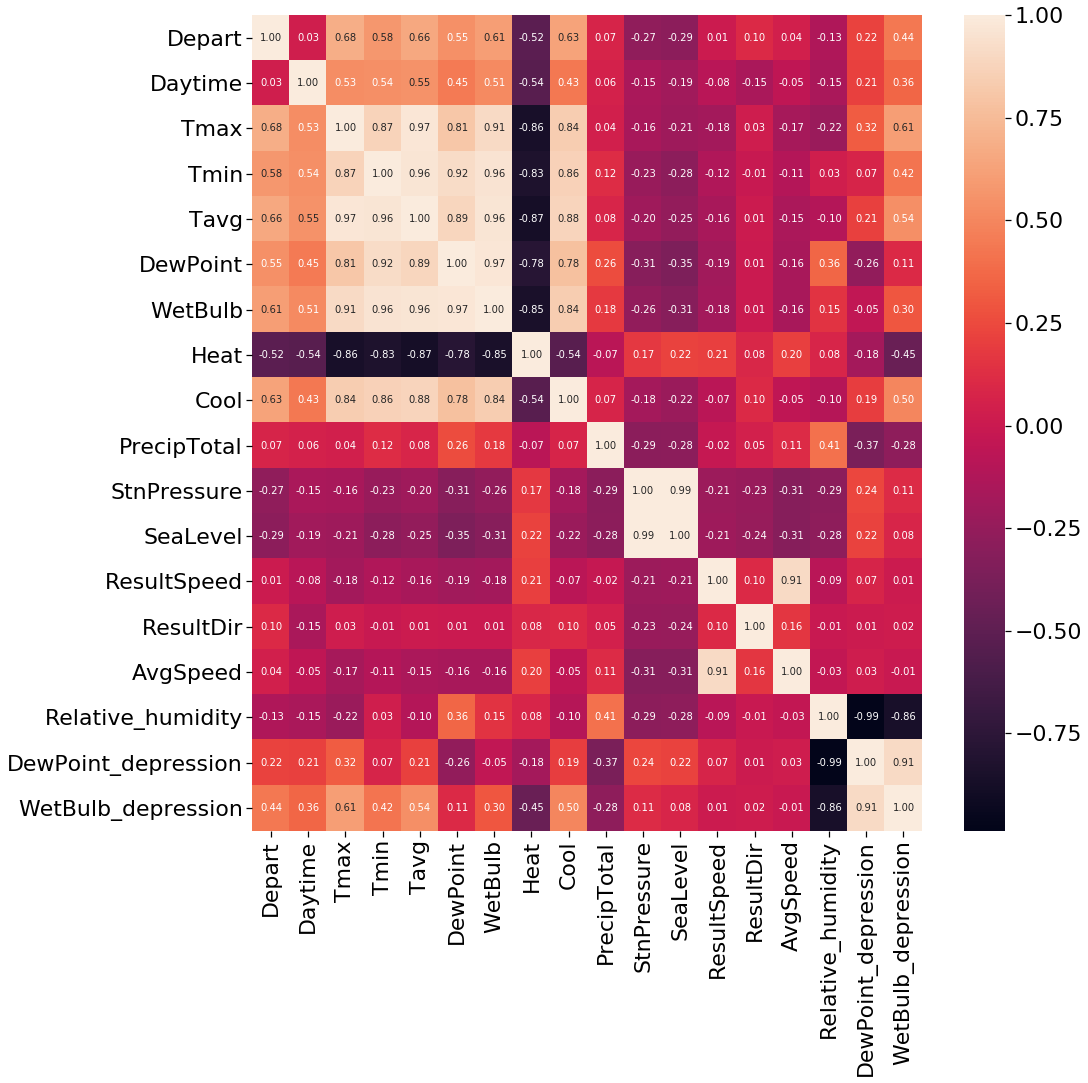

In [88]:
plt.subplots(figsize=(15,15))

corr = dfweather_station.corr(method='pearson')
#sns.heatmap(dfweather_station[weather_features].corr());
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")


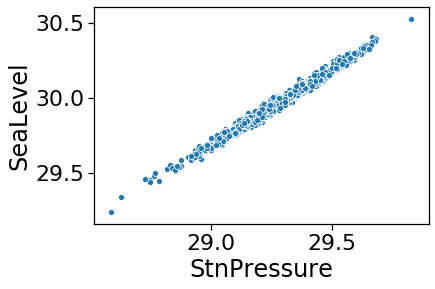

In [89]:
#Highly positive correlation coefficient 0.99  betweenStnPressure and SeaLevel. Similarly,  highly negative correlation coefficient -0.97 between Sunset and Sunrise. 
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig, ax = figsize=(10, 5)
sns.scatterplot(x='StnPressure',y='SeaLevel', data=dfweather_station)
#sns.scatterplot(y='Sunset',x='Sunrise', data=dfweather_station,ax=ax[1])
#plt.subplots_adjust(wspace=0.5)
plt.show()


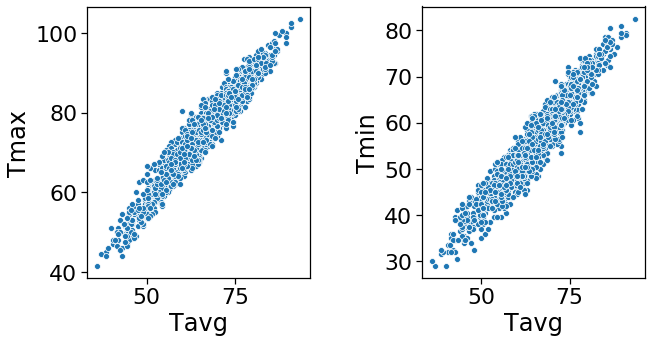

In [90]:
#Correlation coefficient of average temperature and maximum temperature is high 0.96. Similar value for average temperature and minimum temperature
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='Tavg',y='Tmax', data=dfweather_station,ax=ax[0])
sns.scatterplot(x='Tavg',y='Tmin', data=dfweather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

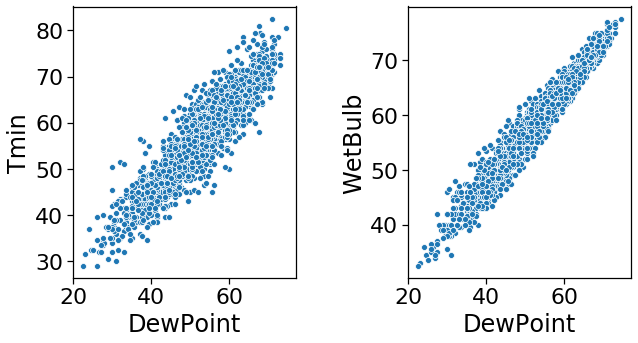

In [91]:
#plots of DewPoint with WetBulb and minimum temperature as they exhibit highly positive correlation coefficients as 0.97 and 0.91 respectively
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='DewPoint',y='Tmin', data=dfweather_station,ax=ax[0])
sns.scatterplot(x='DewPoint',y='WetBulb', data=dfweather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

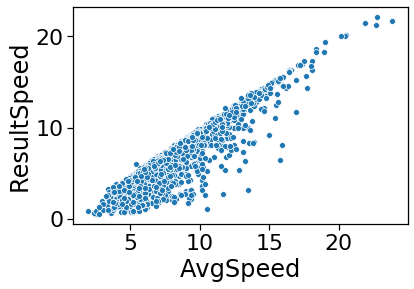

In [92]:
#AvgSpeed and ResultSpeed are highly correlated with 0.91
sns.scatterplot(x='AvgSpeed',y='ResultSpeed', data=dfweather_station)
plt.show()


In [93]:
#Creating Dayofweek,Day week, month, year from date 
dfweather_station['Day_of_week']=dfweather_station['Date'].dt.dayofweek
dfweather_station['Day_of_month']=dfweather_station['Date'].dt.day
dfweather_station['Week']=dfweather_station['Date'].dt.week
dfweather_station['Month']=dfweather_station['Date'].dt.month
dfweather_station['Year']=dfweather_station['Date'].dt.year


In [94]:
def mkseason(n):
    if 3<=n<=5: season = 'Spring'
    elif 6<=n<=8: season = 'Summer'
    elif 9<=n<=11: season = 'Fall'
    else: season = 'Winter'
    return(season)

In [95]:
dfweather_station['Season'] = dfweather_station.Month.apply(mkseason)


In [96]:

def mkmonth(n):
    if n==5: month = 'May'
    elif n==6: month = 'June'
    elif n==7: month = 'July'
    elif n==8: month = 'Aug'
    elif n==9: month = 'Sep'   
    else: month = 'Oct'
    return(month)

In [97]:
dfweather_station['Monthofyear'] = dfweather_station.Month.apply(mkmonth)

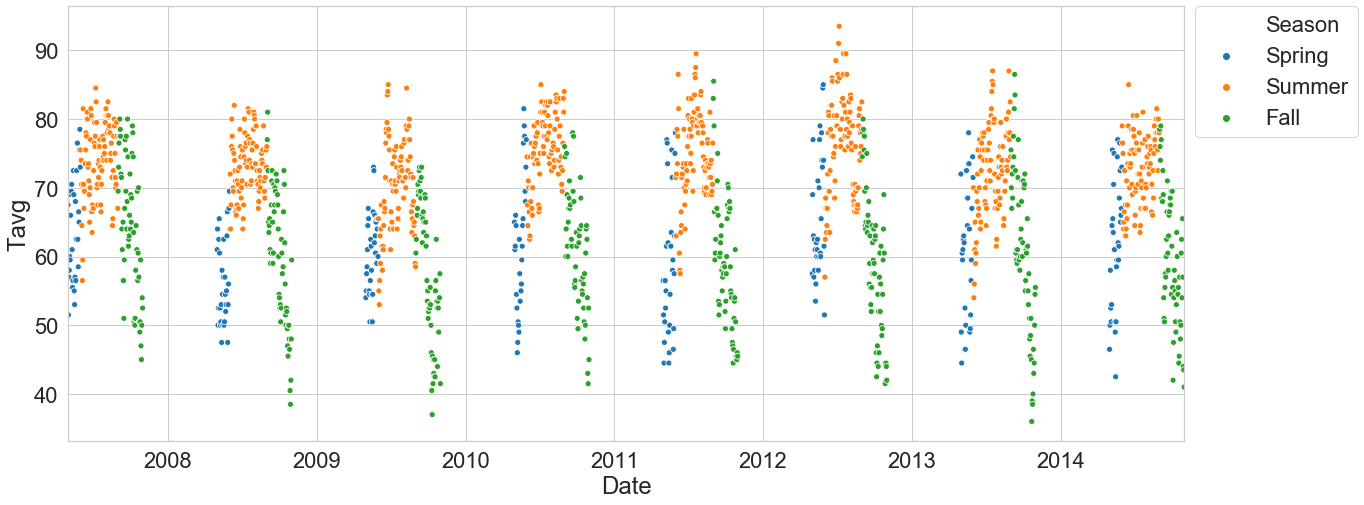

In [98]:
#import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
ax=sns.scatterplot(x="Date", y="Tavg", hue="Season",data=dfweather_station)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
ax.set_xlim(dfweather_station['Date'].min(), dfweather_station['Date'].max())
#myFmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_formatter(myFmt)
#for item in ax.get_xticklabels():
#    item.set_rotation(45)
#plt.show()



plt.show()

## 3. Exploratory data analysis on training data merged with weather data <a id='3._Exploratory data analys on training data merged with weather data'></a>

In [99]:
#Merging training data with weather data on date
df=dftrain.merge(dfweather_station, on = 'Date')

In [100]:
df.shape

(10506, 39)

In [101]:
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Week,Month,Year,Season,Monthofyear
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May


## 3.1 Seasonality of virus <a id='3.1_ Seasonality of virus'></a>

In [102]:
Yearly_count=df.Year.value_counts()
Yearly_wnv=df.groupby('Year')['WnvPresent'].sum().sort_values(ascending=False)
Yearly_count=Yearly_count.to_frame().join(Yearly_wnv.to_frame())
Yearly_count = Yearly_count.rename(columns={'Year': 'Sample', 'WnvPresent': 'Wnv_sample'})
Yearly_count['Wnv_percent']=Yearly_count.Wnv_sample*100/Yearly_count.Sample
Yearly_count.reset_index(inplace=True)
Yearly_count=Yearly_count.rename(columns={'index': 'Year'})
Yearly_count                                                  

,Year,Sample,Wnv_sample,Wnv_percent
0,2007,3811,236,6.192600
1,2013,2392,239,9.991639
2,2009,2249,19,0.844820
3,2011,2054,57,2.775073


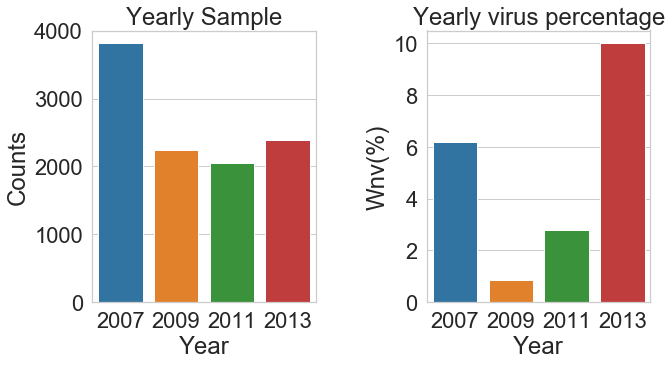

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.figsize=(2, 2)
#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Year", y="Sample", data=Yearly_count,ax=ax[0])
g1.set(ylabel='Counts')
g1.set(title="Yearly Sample")
#g1.set(xlabel=None)
g2=sns.barplot(x="Year", y="Wnv_percent", data=Yearly_count,ax=ax[1])
#plt.get_legend()
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0).remove()
g2.set(ylabel='Wnv(%)')
plt.title("Yearly virus percentage")
plt.subplots_adjust(wspace=0.5)
#g1.set(xlabel=None)
plt.show()

In [104]:
df['Season'].unique()

array(['Spring', 'Summer', 'Fall'], dtype=object)

In [105]:
Season_count=df.Season.value_counts()
Season_wnv=df.groupby('Season')['WnvPresent'].sum().sort_values(ascending=False)
Season_count=Season_count.to_frame().join(Season_wnv.to_frame())
Season_count = Season_count.rename(columns={'Season': 'Sample', 'WnvPresent': 'Wnv_sample'})
Season_count['Wnv_percent']=Season_count.Wnv_sample*100/Season_count.Sample
Season_count.reset_index(inplace=True)
Season_count=Season_count.rename(columns={'index': 'Season'})
#Season_count.set_index(["Season"], inplace = True)
#Season_count.sort_values(by='Wnv_percent',ascending=False)
Season_count

,Season,Sample,Wnv_sample,Wnv_percent
0,Summer,7928,424,5.348133
1,Fall,2494,127,5.092221
2,Spring,84,0,0.000000


Note: Absence of winter season in the data. Mosquitoes die off in winter season due to cold weather. Also, the virus was observed only in the summer and the fall season but not in the spring season.

In [106]:
df_season_year_count=df.groupby([(df.Year),(df.Season)])['Season'].count()
df_season_year_wnv=df.groupby([(df.Year),(df.Season)])['WnvPresent'].sum()
#type(df_month_year_wnv)
dfmerge = pd.concat([df_season_year_count, df_season_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Season': 'Sample', 'WnvPresent': 'Wnv_sample'})
dfmerge['Wnv_percent']=dfmerge.Wnv_sample*100/dfmerge.Sample
dfmerge.reset_index(inplace=True)
dfmerge

,Year,Season,Sample,Wnv_sample,Wnv_percent
0,2007,Fall,985,30,3.045685
1,2007,Spring,25,0,0.000000
2,2007,Summer,2801,206,7.354516
3,2009,Fall,483,5,1.035197
4,2009,Spring,59,0,0.000000
5,2009,Summer,1707,14,0.820152
6,2011,Fall,540,22,4.074074
7,2011,Summer,1514,35,2.311757
8,2013,Fall,486,70,14.403292
9,2013,Summer,1906,169,8.866737


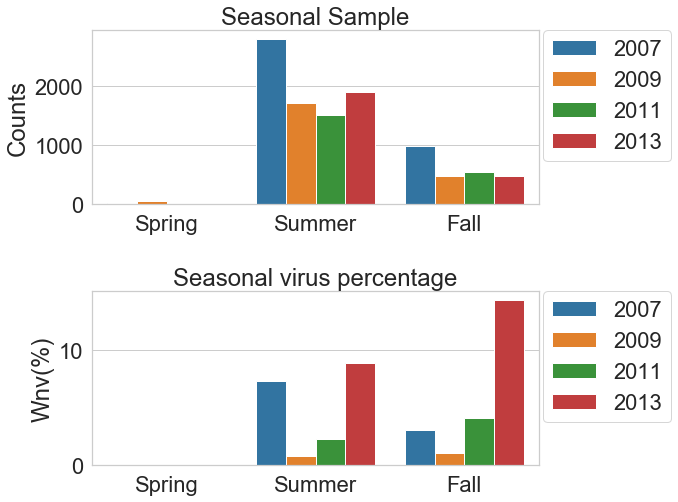

In [107]:
#sns.barplot(data=dfmerge,x="Monthofyear", y="Wnv_percent", hue="Year")
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Season", y="Sample",hue='Year', data=dfmerge,order=['Spring','Summer', 'Fall'],ax=ax[0])
#plt.ylabel('Counts')
g1.set(title="Seasonal Sample")
g1.set(ylabel='Counts')
g1.set(xlabel=None)
g1.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.subplots_adjust(hspace=0.5)

g2=sns.barplot(x="Season", y="Wnv_percent",hue='Year', data=dfmerge,order=['Spring','Summer', 'Fall'],ax=ax[1])
g2.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
#plt.ylabel('Wnv(%)')
plt.title("Seasonal virus percentage")
g2.set(ylabel='Wnv(%)')
g2.set(xlabel=None)

plt.show()

In [108]:
Month_count=df.Monthofyear.value_counts()
Month_wnv=df.groupby('Monthofyear')['WnvPresent'].sum().sort_values(ascending=False)
Month_count=Month_count.to_frame().join(Month_wnv.to_frame())
Month_count = Month_count.rename(columns={'Monthofyear': 'Total_count', 'WnvPresent': 'Wnv_count'})
Month_count['Wnv_percent']=Month_count.Wnv_count*100/Month_count.Total_count
Month_count.sort_values(by='Wnv_percent',ascending=False)

,Total_count,Wnv_count,Wnv_percent
Aug,3751,377,10.050653
Sep,2218,125,5.635708
July,2606,46,1.765157
Oct,276,2,0.724638
June,1571,1,0.063654
May,84,0,0.000000


Virus absent in May. The highest fraction was be observed in August.

In [109]:
df_month_year=df.groupby([(df.Year),(df.Monthofyear)]).mean()[['Tavg','PrecipTotal']]
df_month_year_count=df.groupby([(df.Year),(df.Monthofyear),(df.Month)])['Monthofyear'].count()
df_month_year_wnv=df.groupby([(df.Year),(df.Monthofyear),(df.Month)])['WnvPresent'].sum()
#type(df_month_year_wnv)
dfmerge = pd.concat([df_month_year_count, df_month_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Monthofyear': 'Sample', 'WnvPresent': 'Wnv_sample'})
dfmerge['Wnv_percent']=dfmerge.Wnv_sample*100/dfmerge.Sample
df_mergeA = df_month_year.merge(dfmerge, how='outer', left_index=True, right_index=True)
#df_merge   #.sort_values(by='Wnv_percent',ascending=False)
df_mergeA.reset_index(inplace=True)

In [110]:
#df_mergeA["Month"] = pd.to_datetime(df_mergeA.Monthofyear, format='%b', errors='coerce').dt.month
df_mergeA = df_mergeA.sort_values(["Year", "Month"],ascending = (True, True))

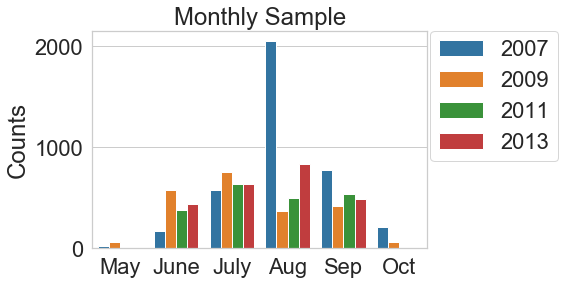

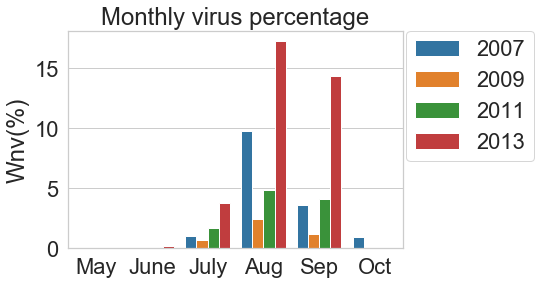

In [111]:
#sns.barplot(data=dfmerge,x="Monthofyear", y="Wnv_percent", hue="Year")
import seaborn as sns
#fig, ax = plt.subplots(2, 1, figsize=(8, 8))

#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Monthofyear", y="Sample",hue='Year', data=df_mergeA)
g1.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Monthly Sample")
plt.ylabel('Counts')
g1.set(xlabel=None)
plt.show()

g2=sns.barplot(x="Monthofyear", y="Wnv_percent",hue='Year', data=df_mergeA)
g2.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.ylabel('Wnv(%)')
plt.title("Monthly virus percentage")

g2.set(xlabel=None)
plt.show()


In [112]:
Week_count=df.Week.value_counts()
Week_wnv=df.groupby('Week')['WnvPresent'].sum().sort_values(ascending=False)
Week_count=Week_count.to_frame().join(Week_wnv.to_frame())
Week_count = Week_count.rename(columns={'Week': 'Sample', 'WnvPresent': 'Wnv_sample'})
Week_count['Wnv_percent']=Week_count.Wnv_sample*100/Week_count.Sample
Week_count.reset_index(inplace=True)
Week_count=Week_count.rename(columns={'index': 'Week'})
Week_count.set_index(["Week"], inplace = True)
Week_count.sort_values(by='Wnv_percent',ascending=False)

,Sample,Wnv_sample,Wnv_percent
Week,,,
34,784,124,15.816327
36,431,53,12.296984
35,513,61,11.890838
33,804,86,10.696517
32,743,65,8.748318
37,532,37,6.954887
31,1241,51,4.109589
38,675,21,3.111111
30,738,20,2.710027


In [167]:
df_week_year_count=df.groupby([(df.Year),(df.Monthofyear),(df.Week)])['Week'].count()
df_week_year_wnv=df.groupby([(df.Year),(df.Monthofyear),(df.Week)])['WnvPresent'].sum()
##type(df_month_year_wnv)
dfmerge = pd.concat([df_week_year_count, df_week_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Week': 'Weekly_sample', 'WnvPresent': 'Wnv_count'})
dfmerge['Wnv_percent']=dfmerge.Wnv_count*100/dfmerge.Weekly_sample


df_week_year=df.groupby([(df.Year),(df.Monthofyear),(df.Week)]).mean()

df_mergeB = df_week_year.merge(dfmerge, how='outer', left_index=True, right_index=True)
df_mergeB.reset_index(inplace=True)
df_mergeB = df_mergeB.sort_values(["Year", "Week"],ascending = (True, True))
df_mergeB

,Year,Monthofyear,Week,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Depart,...,AvgSpeed,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Month,Weekly_sample,Wnv_count,Wnv_percent
11,2007,May,22,36.240000,41.876884,-87.696170,7.920000,1.600000,0.000000,10.000000,...,6.950000,55.630000,17.000000,10.000000,1.000000,29.000000,5.0,25,0,0.000000
9,2007,June,23,36.950000,41.882557,-87.716228,8.200000,2.116667,0.000000,-9.000000,...,7.850000,71.780000,9.000000,5.000000,1.000000,5.000000,6.0,60,0,0.000000
10,2007,June,26,39.379310,41.890366,-87.717315,8.215517,2.594828,0.000000,2.862069,...,7.857759,69.614138,10.715517,7.318966,2.189655,27.189655,6.0,116,0,0.000000
5,2007,July,27,40.702703,41.886917,-87.717122,8.175676,3.243243,0.000000,-6.000000,...,8.300000,54.410000,17.000000,8.500000,0.000000,2.000000,7.0,74,0,0.000000
6,2007,July,28,41.065789,41.852237,-87.705824,8.263158,7.256579,0.000000,-3.000000,...,11.049999,50.950000,19.000000,11.000000,2.000000,11.000000,7.0,152,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,2013,Aug,35,38.545455,41.878329,-87.730881,8.223776,18.496503,0.265734,8.000000,...,4.650000,63.300000,13.500000,9.000000,3.000000,29.000000,8.0,143,38,26.573427
61,2013,Sep,36,37.174825,41.866270,-87.720021,8.111888,17.552448,0.223776,5.000000,...,6.000000,56.280000,16.500000,9.500000,4.000000,6.000000,9.0,143,32,22.377622
62,2013,Sep,37,36.143885,41.863971,-87.712386,8.079137,15.899281,0.165468,7.000000,...,9.600000,61.500000,14.000000,8.500000,3.000000,12.000000,9.0,139,23,16.546763
63,2013,Sep,38,38.366071,41.852899,-87.697402,8.026786,9.196429,0.098214,14.000000,...,10.300000,71.350000,10.000000,7.500000,3.000000,19.000000,9.0,112,11,9.821429


In [114]:
df_mergeB.columns

Index(['Year', 'Monthofyear', 'Week', 'Block', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Depart', 'Daytime',
       'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Relative_humidity', 'DewPoint_depression',
       'WetBulb_depression', 'Day_of_week', 'Day_of_month', 'Month',
       'Weekly_sample', 'Wnv_count', 'Wnv_percent'],
      dtype='object')

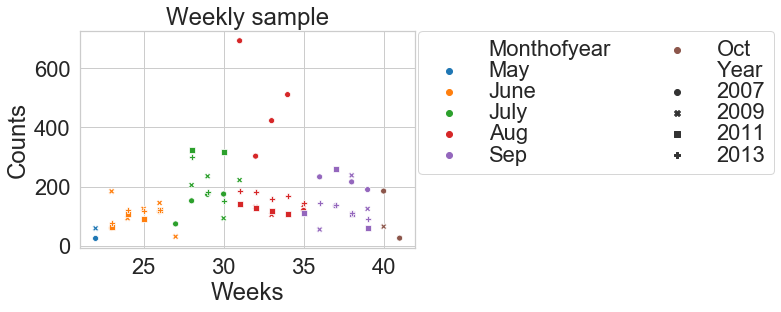

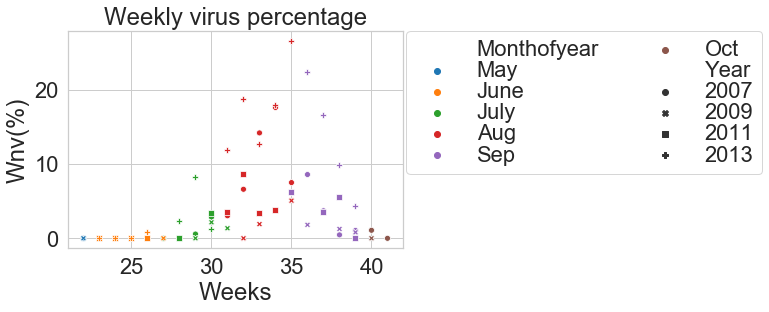

In [115]:
import seaborn as sns
#fig, ax = plt.subplots(2, 1, figsize=(8, 8))
#sns.set_theme(style="whitegrid")
figsize=(15, 8)
g3=sns.scatterplot(x="Week", y="Weekly_sample",style='Year',hue="Monthofyear", data=df_mergeB)
plt.xlabel('Weeks')
plt.ylabel('Counts')
plt.title("Weekly sample")
g3.legend(bbox_to_anchor=(1.01, 1),ncol=2,labelspacing=0.05,borderaxespad=0)
plt.show()


g4=sns.scatterplot(x="Week", y="Wnv_percent",style='Year',hue="Monthofyear", data=df_mergeB)
plt.title("Weekly virus percentage")
plt.xlabel('Weeks')
plt.ylabel('Wnv(%)')
g4.legend(bbox_to_anchor=(1.01, 1),ncol=2,labelspacing=0.05,borderaxespad=0)
plt.show()


## 4. Features selection <a id='4._Features selection'></a>

In [116]:
features = [x for x in df_mergeB.columns if x not in ['Block','Day_of_week', 'Day_of_month', 'Week', 'Month', 'Year', 'Season',
       'Monthofyear','WnvPresent','Wnv_count','Wnv_percent']]

In [117]:
#def scatterplots(columns, ncol=None, figsize=(15, 8)):
def scatterplots(columns, ncol=None,figsize=(15,15)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Wnv_percent', data=df_mergeB, alpha=0.5)
        ax.set(xlabel=col, ylabel='Wnv(%)')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)
        
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

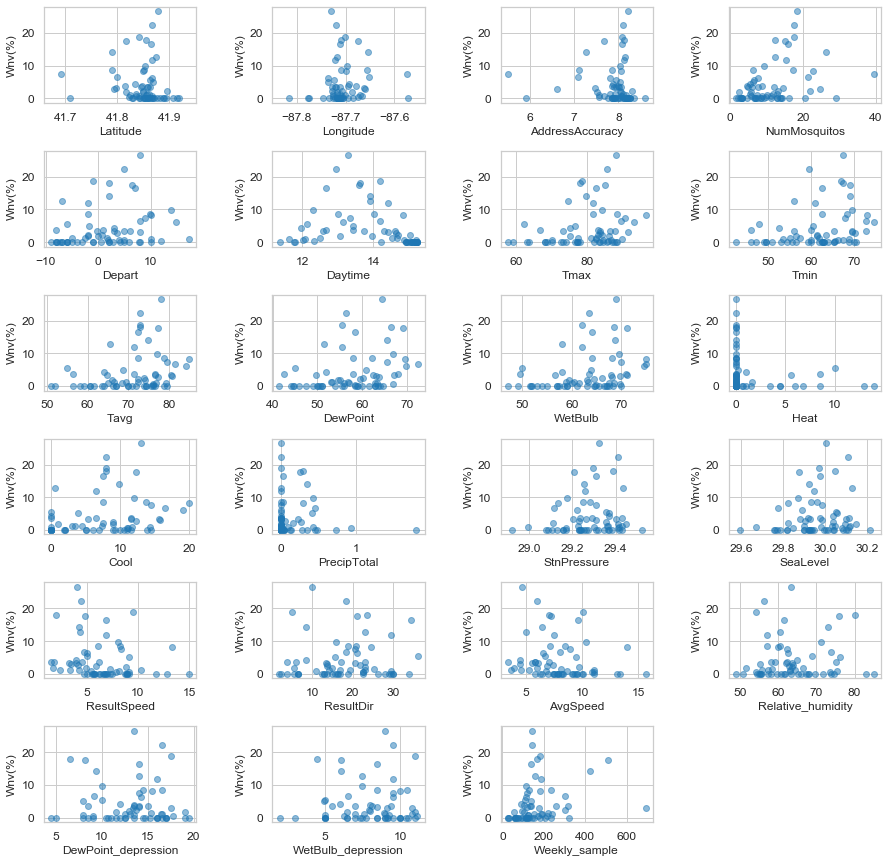

In [118]:
#scatterplots of weekly virus percentage against weather parameters
scatterplots(features, ncol=4)


In [119]:
df.isnull().sum()


Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Depart                    0
Sunrise                   0
Sunset                    0
Daytime                   0
Tmax                      0
Tmin                      0
Tavg                      0
DewPoint                  0
WetBulb                   0
Heat                      0
Cool                      0
PrecipTotal               0
StnPressure               0
SeaLevel                  0
ResultSpeed               0
ResultDir                 0
AvgSpeed                  0
Relative_humidity         0
DewPoint_depression       0
WetBulb_depression        0
Day_of_week               0
Day_of_month              0
Week                      0
Month               

In [120]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Date                    10506 non-null  datetime64[ns] 
 1   Address                 10506 non-null  object         
 2   Species                 10506 non-null  object         
 3   Block                   10506 non-null  int64          
 4   Street                  10506 non-null  object         
 5   Trap                    10506 non-null  object         
 6   AddressNumberAndStreet  10506 non-null  object         
 7   Latitude                10506 non-null  float64        
 8   Longitude               10506 non-null  float64        
 9   AddressAccuracy         10506 non-null  int64          
 10  NumMosquitos            10506 non-null  int64          
 11  WnvPresent              10506 non-null  int64          
 12  Depart                  10506 no

In [121]:
#drop weather features exhibiting highly corrleated features retaining only one of them
# Tmax, Tmin and Tav
#Dewpoint and wetbulb
#Stnpressure and SeaLevel
#ResultSpeend and AverageSpeed
columns_to_drop=['Tmax', 'Tmin', 'DewPoint','StnPressure','AvgSpeed' ]
dff=df.drop(columns=columns_to_drop)
#dff=df

In [122]:
dff.select_dtypes('object').columns


Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Season', 'Monthofyear'],
      dtype='object')

In [123]:
# drop address columns
columns_to_drop=['Date','Address','Block', 'Street','Trap','Sunrise','Sunset','AddressNumberAndStreet','Monthofyear','Season' ]

#df.drop(columns=columns_to_drop, inplace=True)
dff=dff.drop(columns=columns_to_drop)
#df= df.drop(['Date','Address', 'Block', 'Street','Trap','AddressNumberAndStreet', 'NumMosquitos','Monthofyear','Season' ], axis = 1)

In [124]:
#one hot encoding on species
from sklearn.preprocessing import OneHotEncoder
df_encoded =pd.get_dummies(dff, columns=['Species'])

In [125]:
df_encoded.columns

Index(['Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Depart', 'Daytime', 'Tavg', 'WetBulb', 'Heat', 'Cool',
       'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'Relative_humidity', 'DewPoint_depression', 'WetBulb_depression',
       'Day_of_week', 'Day_of_month', 'Week', 'Month', 'Year',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS'],
      dtype='object')

In [126]:
df_encoded.head()

,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Depart,Daytime,Tavg,WetBulb,Heat,...,Week,Month,Year,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
0,41.954690,-87.800991,9,1,0,10,14.93,75.5,65.5,0.0,...,22,5,2007,0,0,1,0,0,0,0
1,41.954690,-87.800991,9,1,0,10,14.93,75.5,65.5,0.0,...,22,5,2007,0,0,0,1,0,0,0
2,41.994991,-87.769279,9,1,0,10,14.93,75.5,65.5,0.0,...,22,5,2007,0,0,0,1,0,0,0
3,41.974089,-87.824812,8,1,0,10,14.93,75.5,65.5,0.0,...,22,5,2007,0,0,1,0,0,0,0
4,41.974089,-87.824812,8,4,0,10,14.93,75.5,65.5,0.0,...,22,5,2007,0,0,0,1,0,0,0


In [127]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        10506 non-null  float64
 1   Longitude                       10506 non-null  float64
 2   AddressAccuracy                 10506 non-null  int64  
 3   NumMosquitos                    10506 non-null  int64  
 4   WnvPresent                      10506 non-null  int64  
 5   Depart                          10506 non-null  int64  
 6   Daytime                         10506 non-null  float64
 7   Tavg                            10506 non-null  float64
 8   WetBulb                         10506 non-null  float64
 9   Heat                            10506 non-null  float64
 10  Cool                            10506 non-null  float64
 11  PrecipTotal                     10506 non-null  float32
 12  SeaLevel                        

In [128]:
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime



In [129]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='WnvPresent'), 
                                                    df_encoded.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [130]:
#Training virus %
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    6963
1     391
Name: WnvPresent, dtype: int64
0    0.946832
1    0.053168
Name: WnvPresent, dtype: float64


In [131]:
#Test virus %
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    2992
1     160
Name: WnvPresent, dtype: int64
0    0.949239
1    0.050761
Name: WnvPresent, dtype: float64


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

dt_clf_4 = DecisionTreeClassifier(max_depth=4)
dt_clf_4.fit(X_train,y_train)
y_pred_4 = dt_clf_4.predict(X_test)
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy)) 

#scale data
#from sklearn import preprocessing
#import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled=scaler.transform(X_train)
#X_test_scaled=scaler.transform(X_test)

In [132]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [133]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
print(model_res)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
#y_pred = model_res.predict(X_test)
#y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Random Forest: Accuracy=0.948
Random Forest: f1-score=0.935


[[2962   30]
 [ 135   25]]


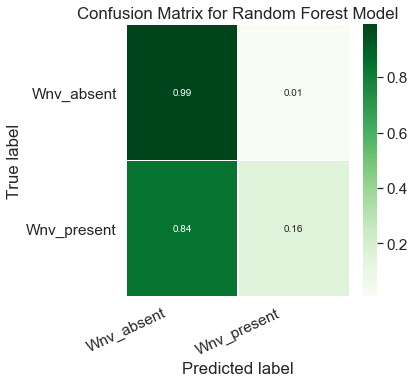

In [134]:
# Get and reshape confusion matrix data
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(5,5))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [135]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2992
           1       0.45      0.16      0.23       160

    accuracy                           0.95      3152
   macro avg       0.71      0.57      0.60      3152
weighted avg       0.93      0.95      0.94      3152



In [136]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [137]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='WnvPresent'), 
                                                    df_encoded.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [138]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7354 entries, 4381 to 5255
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Latitude                        7354 non-null   float64
 1   Longitude                       7354 non-null   float64
 2   AddressAccuracy                 7354 non-null   int64  
 3   NumMosquitos                    7354 non-null   int64  
 4   Depart                          7354 non-null   int64  
 5   Daytime                         7354 non-null   float64
 6   Tavg                            7354 non-null   float64
 7   WetBulb                         7354 non-null   float64
 8   Heat                            7354 non-null   float64
 9   Cool                            7354 non-null   float64
 10  PrecipTotal                     7354 non-null   float32
 11  SeaLevel                        7354 non-null   float32
 12  ResultSpeed                    

In [139]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [140]:
final_iv, IV = data_vars(X_train, y_train)

Latitude
0   -0.133451
1    0.121575
dtype: float64
Longitude
0    0.197940
1   -0.241712
dtype: float64
AddressAccuracy
0    0.002923
1   -0.004730
dtype: float64
NumMosquitos
0   -1.934151
1   -0.935854
2    0.164444
3    0.980866
dtype: float64
Depart
0   -0.370716
1    0.130365
2    0.190995
dtype: float64
Daytime
0    0.565881
1    0.136170
2   -2.246854
dtype: float64
Tavg
0   -0.092446
1    0.088111
dtype: float64
WetBulb
0   -0.235978
1    0.196707
dtype: float64
Heat
0    0.097550
1   -1.370027
dtype: float64
Cool
0   -0.092446
1    0.088111
dtype: float64
PrecipTotal
0    0.027223
1        -inf
dtype: float64
SeaLevel


divide by zero encountered in log


0    0.001051
1   -0.001206
dtype: float64
ResultSpeed
0    0.160421
1    0.044622
2   -0.252848
dtype: float64
ResultDir
0   -0.045285
1    0.049206
dtype: float64
Relative_humidity
0   -0.208012
1   -0.071127
2    0.241500
dtype: float64
DewPoint_depression
0    0.340495
1   -0.045541
2   -0.100235
3   -0.346464
dtype: float64
WetBulb_depression
0    0.082273
1   -0.111286
dtype: float64
Day_of_week
0    0.164329
1   -0.369463
dtype: float64
Day_of_month
0   -0.084008
1   -0.016416
2    0.102381
dtype: float64
Week
0   -1.227932
1    0.575564
dtype: float64
Month
0   -0.034459
1    0.104621
dtype: float64
Year
0   -0.225676
1    0.243313
dtype: float64
Species_CULEX ERRATICUS
Species_CULEX PIPIENS
Species_CULEX PIPIENS/RESTUANS
Species_CULEX RESTUANS
Species_CULEX SALINARIUS
Species_CULEX TARSALIS
Species_CULEX TERRITANS


In [141]:
df_encoded.PrecipTotal.unique()

array([0.        , 0.345     , 0.0825    , 1.235     , 0.085     ,
       0.0025    , 0.105     , 0.68499994, 0.075     , 0.255     ,
       0.53      , 0.0075    , 0.625     , 0.22      , 0.13      ,
       0.14      , 0.09      , 0.005     , 2.42      , 0.09999999,
       0.16499999, 0.025     , 0.28      , 1.07      , 0.74      ,
       0.48      , 0.0175    , 0.26      , 0.01      , 0.45000002,
       0.755     , 0.66999996, 0.2925    , 0.29500002, 0.0325    ,
       0.42249998], dtype=float32)

In [142]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
X2.head()

,Day_of_week,Depart,DewPoint_depression,Heat,Latitude,Longitude,Relative_humidity,ResultSpeed,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Week,WetBulb,Year
4381,4,7,18.0,0.0,41.991429,-87.747113,54.10,6.40,0,1,26,67.0,2009
8001,4,-6,10.0,10.0,41.754676,-87.612922,68.95,5.00,0,1,38,50.0,2011
8465,3,6,12.0,0.0,41.801179,-87.679447,66.69,6.65,0,1,26,69.5,2013
8840,4,-2,17.5,0.0,41.987280,-87.666066,53.99,4.05,0,0,28,61.5,2013
1062,2,8,18.0,0.0,41.836644,-87.677737,54.38,2.80,1,0,31,69.5,2007


In [143]:
X2.columns

Index(['Day_of_week', 'Depart', 'DewPoint_depression', 'Heat', 'Latitude',
       'Longitude', 'Relative_humidity', 'ResultSpeed',
       'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS', 'Week', 'WetBulb',
       'Year'],
      dtype='object')

In [144]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Longitude with VIF of 1001572.590384
Iteration # 2
Removing Year with VIF of 147114.840648
Iteration # 3
Removing Latitude with VIF of 15700.077835
Iteration # 4
Removing WetBulb with VIF of 672.000193
Iteration # 5
Removing Week with VIF of 66.184053
Iteration # 6
Removing Relative_humidity with VIF of 12.101248
Iteration # 7
Removing DewPoint_depression with VIF of 6.252039
Iteration # 8
Complete


In [145]:
X_train=final_df
X_train.head()

,Day_of_week,Depart,Heat,ResultSpeed,Species_CULEX PIPIENS,Species_CULEX RESTUANS
4381,4,7,0.0,6.40,0,1
8001,4,-6,10.0,5.00,0,1
8465,3,6,0.0,6.65,0,1
8840,4,-2,0.0,4.05,0,0
1062,2,8,0.0,2.80,1,0


In [146]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [147]:
X_test=X_test[X_train.columns]
X_test.head()

,Day_of_week,Depart,Heat,ResultSpeed,Species_CULEX PIPIENS,Species_CULEX RESTUANS
8876,4,10,0.0,13.35,0,0
2468,2,9,0.0,5.20,1,0
6763,4,5,0.0,5.80,1,0
2205,1,7,0.0,3.65,1,0
4667,0,-3,0.0,5.30,0,0


Accuracy of logistic regression classifier on test set: 0.95

Confusion matrix: 
 [[2992    0]
 [ 160    0]]

Classification report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2992
           1       0.00      0.00      0.00       160

    accuracy                           0.95      3152
   macro avg       0.47      0.50      0.49      3152
weighted avg       0.90      0.95      0.92      3152



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


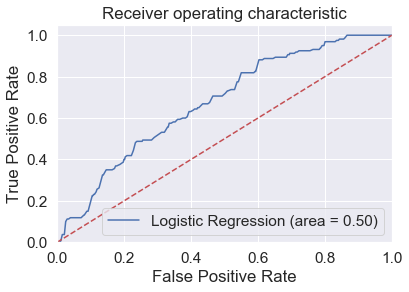

In [148]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [149]:
np.linspace(0.1, 1.0, 10, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [150]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression

# Instantiate model
lr = LogisticRegression(C=1, tol=0.1, multi_class='ovr', class_weight=dict({1:49, 0:1}), solver='newton-cg', max_iter=10, n_jobs=-1, verbose=2)
# Train the model on training data
lr.fit(X_train, y_train)

y_pred2 = lr.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


0.5796290106951871

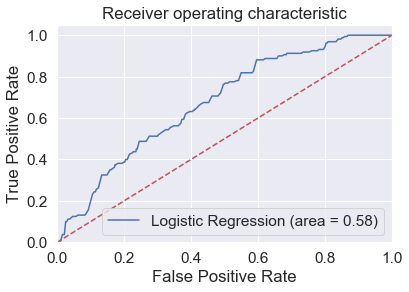

In [151]:
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
  

In [152]:
conf2 = confusion_matrix(y_test, y_pred2.round())
conf2

array([[ 570, 2422],
       [   5,  155]])

In [153]:
y_test.value_counts()

0    2992
1     160
Name: WnvPresent, dtype: int64

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[[1756 1236]
 [  27  133]]


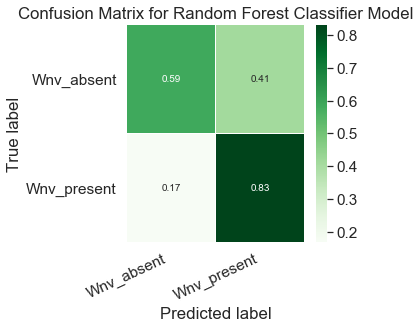

In [154]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)

roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()



In [155]:
# Import the model we are using
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3


[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=15
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=17
[21:11:32] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=18
[21:11:32] INFO: src/tree/updater_prune.

0.7125167112299465

[[1627 1365]
 [  19  141]]


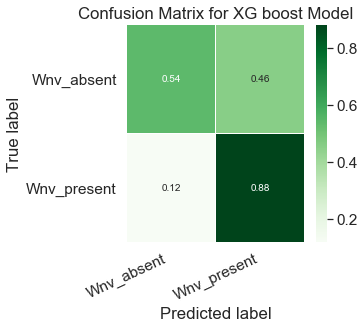

In [156]:
#conf3 = confusion_matrix(y_test, y_pred3)
#conf3
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()




In [157]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.54      0.70      2992
           1       0.09      0.88      0.17       160

    accuracy                           0.56      3152
   macro avg       0.54      0.71      0.44      3152
weighted avg       0.94      0.56      0.67      3152



0.7125167112299465


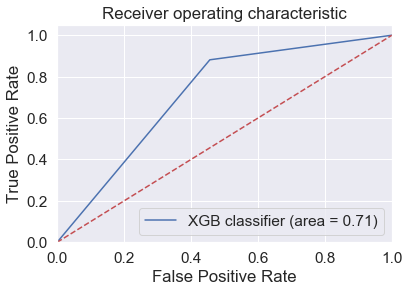

In [158]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
  

In [159]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [160]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

model = XGBClassifier( n_jobs=-1, random_state = 42, verbosity=2)

In [161]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 619 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.5min finished


[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[21:13:05] INFO: src/tree/updater_prune.

[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.

In [162]:
print(model.best_score_)
print(model.best_params_)

0.8045591030471236
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 11, 'scale_pos_weight': 49}


In [163]:
xgb = XGBClassifier(eta=0.01, max_depth=11, scale_pos_weight=49, max_delta_step=4, grow_policy='depthwise', n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.

[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=11
[21:13:06] INFO: src/tree/updater_prune.

0.712683823529412


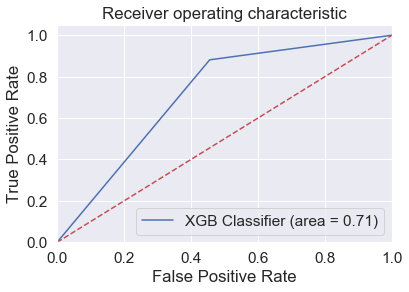

In [164]:
roc = roc_auc_score(y_test, y_pred)
print(roc)


fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

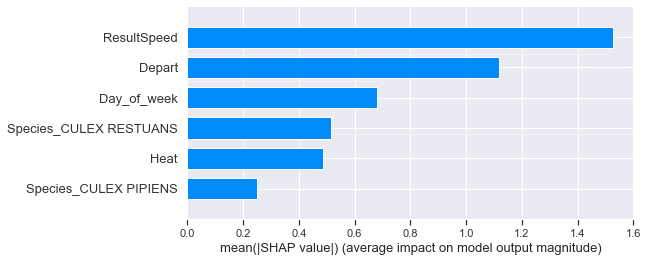

In [165]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

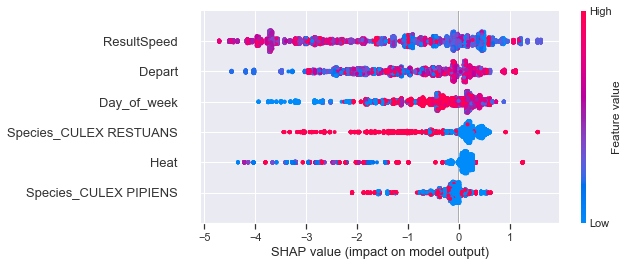

In [166]:
shap.summary_plot(shap_values, X_train)